<a href="https://colab.research.google.com/github/drahulnayak/EEG-Signal-Classification/blob/main/Copy_of__1_Final_Project_submission_of_Rahul_on_EEG_signal_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install deap gdown lightgbm xgboost catboost imbalanced-learn

#DEAP is a Genetic algorithm

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from concurrent.futures import ThreadPoolExecutor, TimeoutError


In [21]:
import numpy as np
import scipy.io
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from deap import base, creator, tools, algorithms
import random

In [22]:
import os
import torch
import pandas as pd
import numpy as np
import json

# Path to CSV files
csv_files_directory = '/content/'  # update if needed

# Define column names (16 EEG channels, plus extra if your data has more)
relevant_columns = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4',
                    'CP5', 'CP1', 'CP2', 'CP6', 'P3', 'Pz',
                    'P4', 'O1', 'Oz', 'O2']

tensors = []
labels = []

for file_name in os.listdir(csv_files_directory):
    if file_name.endswith('.csv'):
        csv_file_path = os.path.join(csv_files_directory, file_name)

        # Read CSV and assign column names
        df = pd.read_csv(csv_file_path, header=None)  # no header in your CSV
        df.columns = relevant_columns + list(range(df.shape[1] - len(relevant_columns)))  # extra columns if any

        # For simplicity, assign a dummy label (all "Innocent")
        label = 'Innocent'

        # Extract relevant channels
        channel_data = [df[col].values for col in relevant_columns]

        # Make all channels the same length
        min_length = min([len(ch) for ch in channel_data])
        channel_data = [ch[:min_length] for ch in channel_data]

        # Stack channels
        data_array = np.stack(channel_data, axis=0)

        # Convert to torch tensor
        tensor_data = torch.tensor(data_array, dtype=torch.float32)
        tensors.append(tensor_data)
        labels.append(label)

# Determine the maximum size for each dimension
max_shape = tuple(max(sizes) for sizes in zip(*[t.size() for t in tensors]))

# Save max_shape to JSON
with open('max_shape.json', 'w') as f:
    json.dump(max_shape, f)

# Pad tensors
padded_tensors = []
for t in tensors:
    pad_size = [(0, max_dim - cur_dim) for cur_dim, max_dim in zip(t.size(), max_shape)]
    pad_size = [item for sublist in pad_size for item in sublist][::-1]
    padded_tensors.append(torch.nn.functional.pad(t, pad_size))

# Stack tensors
stacked_tensor = torch.stack(padded_tensors)

print('Stacked tensor shape:', stacked_tensor.shape)
print('Number of labels:', len(labels))



Stacked tensor shape: torch.Size([36, 16, 31000])
Number of labels: 36


In [23]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print("Classes:", label_encoder.classes_)


Classes: ['Innocent']


In [24]:

################################################################################
# Step 2: Simulate Dataset
################################################################################
# You can replace this with your own X, y
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


X, y = make_classification(
    n_samples=3000,
    n_features=2000,
    n_informative=50,
    n_redundant=0,
    n_classes=2,
    weights=[0.7,0.3],
    flip_y=0.01,
    random_state=42
)

# Standardize for KMeans clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering into 3 batches
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Split dataset into 3 batches
datasets = []
for cluster_id in range(3):
    idx = np.where(clusters == cluster_id)[0]
    X_cluster = X[idx]
    y_cluster = y[idx]
    datasets.append((X_cluster, y_cluster))
    print(f"Batch {cluster_id+1}: {X_cluster.shape[0]} samples")

Batch 1: 1083 samples
Batch 2: 616 samples
Batch 3: 1301 samples


In [25]:
!pip install catboost
!pip install "dask[dataframe]"


In [26]:

################################################################################
# Step 3: Define Classifiers
################################################################################
base_classifiers = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LogReg": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=6),
    "LightGBM": LGBMClassifier(
        n_estimators=200,
        max_depth=6,
        min_data_in_leaf=10,
        learning_rate=0.1,
        boosting_type="gbdt",
        verbose=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        verbosity=0,
        use_label_encoder=False,
        eval_metric="logloss"
    ),
    "CatBoost": CatBoostClassifier(
        iterations=200,
        depth=6,
        learning_rate=0.1,
        verbose=0
    )
}

# New Section

# New Section

In [18]:
################################################################################
# Step 4: Faster Train and Evaluate per Batch
################################################################################
import warnings

# Suppress deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

variance_selector = VarianceThreshold(threshold=0.01)
top_models_per_batch = []
all_accuracies = {}

def safe_fit(clf, X, y, timeout=60):
    def train():
        clf.fit(X, y)
        return clf
    with ThreadPoolExecutor(max_workers=1) as executor:
        future = executor.submit(train)
        try:
            return future.result(timeout=timeout)
        except TimeoutError:
            raise TimeoutError("Training exceeded timeout and was stopped.")

for batch_idx, (X_batch, y_batch) in enumerate(datasets):
    print(f"\n=== Batch {batch_idx+1} ===")

    X_train, X_test, y_train, y_test = train_test_split(
        X_batch, y_batch, test_size=0.2, stratify=y_batch, random_state=42
    )

    # Variance threshold
    X_train = variance_selector.fit_transform(X_train)
    X_test = variance_selector.transform(X_test)

    # PCA with capped components
    n_components = min(300, X_train.shape[0], X_train.shape[1])
    print(f"PCA reducing to {n_components} features...")
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    # SMOTE with default strategy
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    batch_models = []
    for name, clf in base_classifiers.items():
        # Remove KNN from Bagging for speed
        if name == "KNN":
            bag = clf
        else:
            bag = BaggingClassifier(clf, n_estimators=3, max_samples=0.8, random_state=42)
        try:
            safe_fit(bag, X_train, y_train, timeout=60)
            train_acc = bag.score(X_train, y_train)
            test_acc = bag.score(X_test, y_test)
            print(f"{name}: Train {train_acc:.3f}, Test {test_acc:.3f}")
            all_accuracies[f"Batch{batch_idx+1}_{name}"] = (train_acc, test_acc)
            batch_models.append((name, bag, test_acc))
        except Exception as e:
            print(f"Skipping {name} due to error: {e}")

    # Select top N
    N = 3 if batch_idx == 0 else 2
    top = sorted(batch_models, key=lambda x: x[2], reverse=True)[:N]
    top_models_per_batch.append(top)



=== Batch 1 ===
PCA reducing to 300 features...
KNN: Train 0.511, Test 0.304
LogReg: Train 0.950, Test 0.820
RandomForest: Train 0.984, Test 0.599


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

LightGBM: Train 0.969, Test 0.806
XGBoost: Train 0.976, Test 0.829
CatBoost: Train 0.977, Test 0.728

=== Batch 2 ===
PCA reducing to 300 features...
KNN: Train 0.500, Test 0.323
LogReg: Train 0.949, Test 0.815
RandomForest: Train 0.979, Test 0.492


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

LightGBM: Train 0.959, Test 0.718
XGBoost: Train 0.956, Test 0.710
CatBoost: Train 0.968, Test 0.637

=== Batch 3 ===
PCA reducing to 300 features...
KNN: Train 0.523, Test 0.295
LogReg: Train 0.949, Test 0.793
RandomForest: Train 0.991, Test 0.705


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

LightGBM: Train 0.984, Test 0.854
XGBoost: Train 0.987, Test 0.881
CatBoost: Train 0.983, Test 0.762


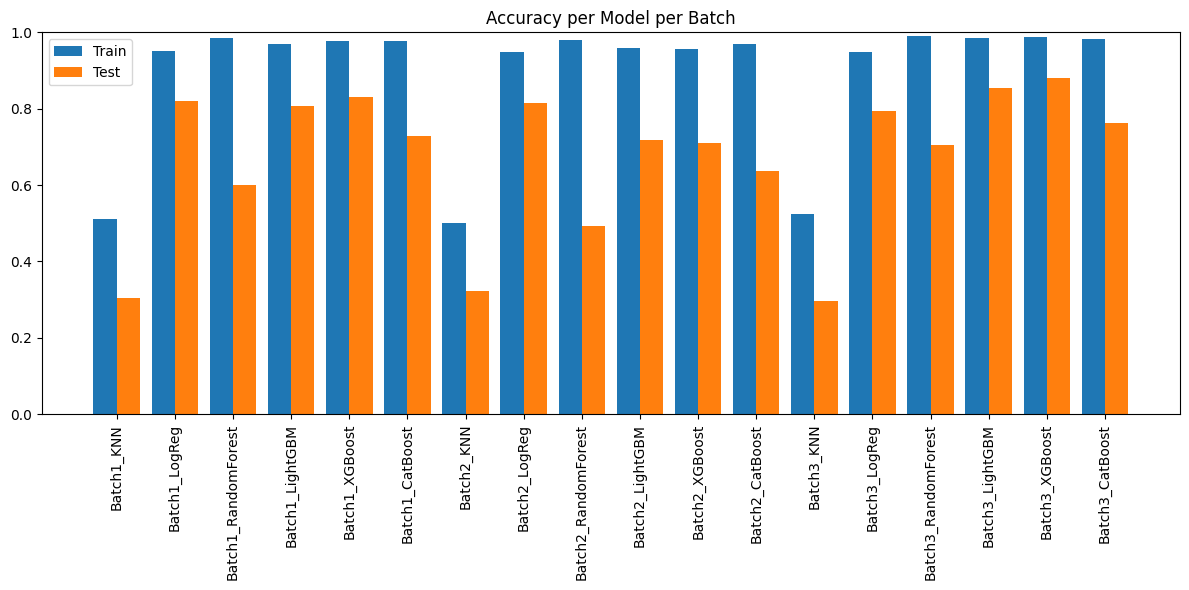

In [27]:

################################################################################
# Step 5: Accuracy Graphs
################################################################################
plt.figure(figsize=(12,6))
x = np.arange(len(all_accuracies))
train_scores = [v[0] for v in all_accuracies.values()]
test_scores = [v[1] for v in all_accuracies.values()]
labels = list(all_accuracies.keys())

plt.bar(x-0.2, train_scores, width=0.4, label="Train")
plt.bar(x+0.2, test_scores, width=0.4, label="Test")
plt.xticks(x, labels, rotation=90)
plt.title("Accuracy per Model per Batch")
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:

################################################################################
# Step 8: Layered Voting Pipeline with Outputs per Layer
################################################################################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Split again, stratified
X_train_layer, X_layer, y_train_layer, y_layer = train_test_split(
    datasets[0][0], datasets[0][1], test_size=0.2, random_state=42, stratify=datasets[0][1]
)

X_layer = variance_selector.transform(X_layer)
if X_layer.shape[1] > 1500:
    X_layer = pca.transform(X_layer)

def majority_vote(models, X, threshold="majority"):

    preds = [m.predict(X) for _, m, _ in models]
    votes = np.sum(preds, axis=0)
    if threshold == "soft":
        binary_preds = (votes >= 1).astype(int)
    else:
        binary_preds = (votes > len(models)/2).astype(int)
    return binary_preds, votes

# Layer 1
preds1, votes1 = majority_vote(top_models_per_batch[0], X_layer)
layer1_indices = np.where(preds1 == 1)[0]

print("\n=== Layer 1 ===")
print(f"Votes: {votes1}")
print(f"Predictions: {preds1}")
print(f"Indices passed to Layer 2: {layer1_indices}")
print(f"Remaining samples: {len(layer1_indices)}")

X_layer = X_layer[layer1_indices]
y_layer = y_layer[layer1_indices]

# Layer 2
preds2, votes2 = majority_vote(top_models_per_batch[1], X_layer)
layer2_indices = np.where(preds2 == 1)[0]

print("\n=== Layer 2 ===")
print(f"Votes: {votes2}")
print(f"Predictions: {preds2}")
print(f"Indices passed to Layer 3: {layer2_indices}")
print(f"Remaining samples: {len(layer2_indices)}")
#layer 3
X_layer = X_layer[layer2_indices]
y_layer = y_layer[layer2_indices]
if len(X_layer) > 0:
    preds3, votes3 = majority_vote(top_models_per_batch[2], X_layer)
    final_indices = np.where(preds3 == 1)[0]

    print("\n=== Layer 3 ===")
    print(f"Votes: {votes3}")
    print(f"Predictions: {preds3}")
    print(f"Final selected indices: {final_indices}")
    print(f"Remaining samples in final: {len(final_indices)}")

    final_pred = np.zeros(len(y_layer))
    final_pred[final_indices] = 1
    acc = accuracy_score(y_layer, final_pred)
    print(f"\n✅ Final Layered Accuracy: {acc:.4f}")
else:
    print("\n⛔ No samples left to process in Layer 3.")


=== Layer 1 ===
Votes: [0 3 2 1 3 3 1 0 3 3 3 0 2 1 0 0 3 1 1 0 3 1 3 1 0 3 0 1 3 1 1 3 0 3 3 2 1
 0 0 1 0 0 0 2 3 2 3 0 0 0 0 1 0 0 3 0 0 0 0 2 1 0 0 3 2 0 1 1 1 0 2 0 0 2
 2 2 0 2 3 0 0 3 3 3 2 3 3 0 3 0 0 1 3 0 2 0 0 3 1 0 3 3 3 2 0 1 0 3 3 3 2
 0 2 1 0 3 3 2 1 0 0 2 1 0 3 0 1 3 0 3 3 3 3 3 0 0 2 0 0 0 2 0 0 3 0 0 3 0
 1 3 0 0 3 2 3 0 0 3 3 0 0 1 0 0 0 0 0 0 0 0 0 1 3 1 3 0 0 3 2 0 2 3 0 0 0
 3 0 0 3 0 2 3 1 3 0 1 2 3 0 0 3 0 0 3 2 2 0 0 2 0 3 0 0 1 2 2 1]
Predictions: [0 1 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 1 1 0
 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1
 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1
 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0
 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 1 0]
Indices passed to Layer 2: [  1   2   4   5   8   9  10  12  16  20  22  25  28  

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

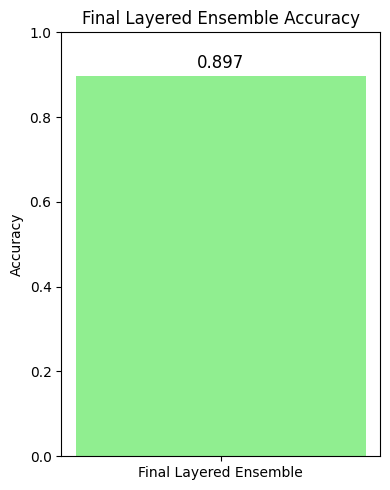

In [29]:
import matplotlib.pyplot as plt

final_layered_accuracy = acc # Replace with your value

plt.figure(figsize=(4,5))
bar = plt.bar(['Final Layered Ensemble'], [final_layered_accuracy], color='lightgreen')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Final Layered Ensemble Accuracy')

plt.text(bar[0].get_x() + bar[0].get_width()/2, final_layered_accuracy + 0.02, f'{final_layered_accuracy:.3f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()


In [32]:
!pip install scikit-learn matplotlib seaborn


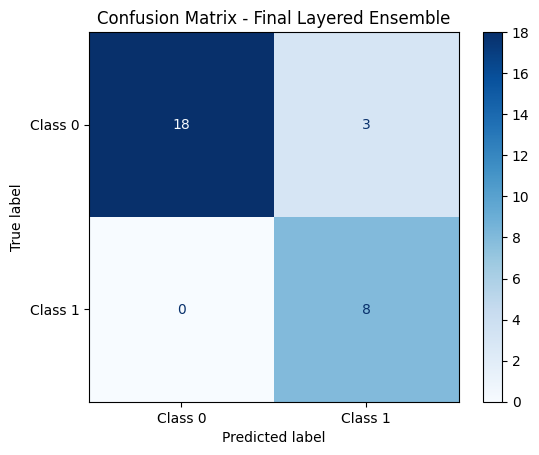

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_layer, final_pred)

# Display
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Class 0", "Class 1"]
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Final Layered Ensemble")
plt.show()
